*Performed on Google Colab*

**Convolutional Neural Network**

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import math
from datetime import timedelta

%matplotlib inline

In [50]:
tf.__version__

'1.9.0-rc2'

**Configuration of  Model**

In [0]:
#Layer 1
f1 = 5
n_filter_1 = 16
#Layer 2
f2 = 5
n_filter_2 = 36
#Fully Connected Layer
neurons = 128

**Load the data**

In [52]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/',one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [53]:
#Printing the size of the various datasets
print("Size of training data: "+str(len(data.train.labels)))
print("Size of test data: "+str(len(data.test.labels)))
print("Size of validation data: "+str(len(data.validation.labels)))

Size of training data: 55000
Size of test data: 10000
Size of validation data: 5000


In [0]:
data.test.cls = np.argmax(data.test.labels,axis=1)

**Data Dimension**

In [0]:
img_size = 28
img_shape = (img_size,img_size)
img_flat_size = img_size * img_size
#All the images are the gray scale images. Therefore, a single channel.
n_channels = 1
n_classes = 10

**Helper Function for plotting images**

In [0]:
def plot_images(images,y_true,y_pred=None):
  assert len(images) == len(y_true) == 9
  
  fig, axes = plt.subplots(3,3)
  fig.subplots_adjust(hspace=0.5,wspace=0.5)
  
  for indx, ax in enumerate(axes.flat):
    ax.imshow(images[indx].reshape(img_shape),cmap=plt.cm.gray_r)
    
    if y_pred is None:
      xlabel = 'True: ' + str(y_true[indx])
    else:
      xlabel = 'True: ' + str(y_true[indx]) + '::Predicted: ' + str(y_pred[indx])
    
    ax.set_xlabel(xlabel)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
  plt.show()

**Plotting few images**

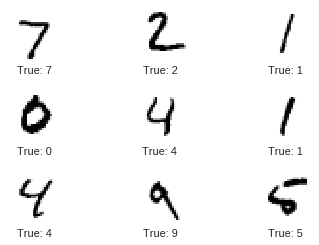

In [57]:
images = data.test.images[:9]
y_true = data.test.cls[:9]

plot_images(images,y_true)

**TensorFlow Graph**

In [0]:
def new_weights(shape):
  return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

def new_baises(length):
  return tf.Variable(tf.constant(0.,shape=[length,]))

**Helper Function for Convolutional Layer**

In [0]:
def new_conv_layer(input,n_input_channels,filter_size,n_filters,use_pooling=True):
  shape = [filter_size,filter_size,n_input_channels,n_filters]
  
  weights = new_weights(shape)
  baises = new_baises(n_filters)
  
  layer = tf.nn.conv2d(input=input,filter=weights,strides=[1,1,1,1],padding='SAME')
  
  layer = layer + baises
  
  if use_pooling:
    layer = tf.nn.max_pool(value=layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
  
  layer = tf.nn.relu(layer)
  
  return layer, weights

**Helper Function for flattening a layer**

In [0]:
def flatten_layer(layer):
  layer_shape = layer.get_shape()
  num_features = layer_shape[1:].num_elements()
  
  layer_flat = tf.reshape(layer,[-1,num_features])
  return layer_flat, num_features

**Helper Function for fully connected layer**

In [0]:
def new_fc_layer(input,num_inputs,num_outputs,use_relu=True):
  weights = new_weights(shape=[num_inputs,num_outputs])
  baises = new_baises(num_outputs)
  
  layer = tf.matmul(input,weights) + baises
  
  if use_relu:
    layer = tf.nn.relu(layer)
    
  return layer

**Placeholder Variables**

In [0]:
X = tf.placeholder(tf.float32,shape=[None,img_flat_size])
X_image = tf.reshape(X,[-1,img_size,img_size,n_channels])

y = tf.placeholder(tf.float32,shape=[None,n_classes])
y_cls = tf.argmax(y,axis=1)

**Convolutional Layer 1**

In [0]:
layer1, weight1 = new_conv_layer(X_image,n_channels,f1,n_filter_1,True)

In [64]:
layer1

<tf.Tensor 'Relu_3:0' shape=(?, 14, 14, 16) dtype=float32>

**Convolutinoal Layer 2**

In [0]:
layer2, weight2 = new_conv_layer(layer1,n_filter_1,f2,n_filter_2,True)

In [66]:
layer2

<tf.Tensor 'Relu_4:0' shape=(?, 7, 7, 36) dtype=float32>

**Flatten Layer**

In [0]:
layer_flat, num_features = flatten_layer(layer2)

In [68]:
layer_flat

<tf.Tensor 'Reshape_3:0' shape=(?, 1764) dtype=float32>

In [69]:
num_features

1764

**Fully Connected Layer 1**

In [0]:
layer_fc1 = new_fc_layer(layer_flat,num_features,neurons,use_relu='True')

In [71]:
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

**Fully Connected Layer 2**

In [0]:
layer_fc2 = new_fc_layer(layer_fc1,neurons,n_classes,False)

In [73]:
layer_fc2

<tf.Tensor 'add_7:0' shape=(?, 10) dtype=float32>

**Predicted Class**

In [0]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred,axis=1)

**Cost to be optimized**

In [0]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,labels=y))

**Optimization Method**

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

In [0]:
correct_prediction = tf.equal(y_pred_cls,y_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
batch_size = 256

In [0]:
total_iterations = 0

def optimize(n_iterations):
  global total_iterations
  
  start = time.time()
  for i in range(n_iterations):
    x_batch, y_batch = data.train.next_batch(batch_size)
    feed_dict = {X:x_batch,y:y_batch}
    
    sess.run(optimizer,feed_dict=feed_dict)
    
    if i%1000 == 0:
      acc = sess.run(accuracy,feed_dict=feed_dict)
      print('Iteration: '+ str(i) + ' Training Accuracy: '+  str(acc))
  total_iterations += n_iterations
  end = time.time()
  
  print('Time Usage: '+ str(end-start))

**Helper Function to plot example errors**

In [0]:
def plot_example_errors(y_pred,correct):
  incorrect = (correct == False)
  
  images = data.test.images[incorrect]
  y_pred = y_pred[incorrect]
  y_true = data.test.cls[incorrect]
  
  plot_images(images[:9],y_true[:9],y_pred[:9])

**Helper Function for Confusion Matrix**

In [0]:
def print_confusion_matrix(y_pred):
  y_true = data.test.cls
  
  cm = confusion_matrix(y_true=y_true,y_pred=y_pred)
  
  print(cm)
  
  #Plot Confusion Matrix as an image
  plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Spectral)
  
  plt.tight_layout()
  plt.colorbar()
  tick_marks = np.arange(n_classes)
  plt.xticks(tick_marks,range(n_classes))
  plt.yticks(tick_marks,range(n_classes))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  
  plt.show()

**Helper Function for showing performance**

In [0]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,show_confusion_matrix=False):
  n_test = len(data.test.labels)
  
  cls_pred = np.zeros(shape=n_test,dtype=np.int)
  
  i=0
  while i < n_test:
    j = min(i+test_batch_size,n_test)
    
    images = data.test.images[i:j]
    labels = data.test.labels[i:j]
    
    feed_dict = {X:images,y:labels}
    cls_pred[i:j] = sess.run(y_pred_cls,feed_dict=feed_dict)
    
    i = j
  
  cls_true = data.test.cls
  correct = cls_true == cls_pred
  correct_sum = correct.sum()
  acc = float(correct_sum) / n_test
  print('Accuracy: '+str(acc))
  
  if show_example_errors:
    print('Example errors: ')
    plot_example_errors(cls_pred,correct)
    
  if show_confusion_matrix:
    print('Confusion Matrix: ')
    print_confusion_matrix(cls_pred)

In [84]:
print_test_accuracy()

Accuracy: 0.1472


**Performance after 1 optimization iteration** 

In [85]:
optimize(1)

Iteration: 0 Training Accuracy: 0.234375
Time Usage: 0.16850996017456055


In [86]:
print_test_accuracy()

Accuracy: 0.2075


**Performance after 100 optimization iteration** 

In [93]:
optimize(100)

Iteration: 0 Training Accuracy: 0.9609375
Time Usage: 1.1943340301513672


Accuracy: 0.9744
Example errors: 


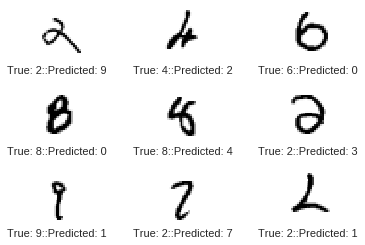

In [94]:
print_test_accuracy(show_example_errors=True)

**Performance after 1000 optimization iteration** 

In [95]:
optimize(1000)

Iteration: 0 Training Accuracy: 0.96875
Iteration: 100 Training Accuracy: 0.9765625
Iteration: 200 Training Accuracy: 0.97265625
Iteration: 300 Training Accuracy: 0.984375
Iteration: 400 Training Accuracy: 0.9921875
Iteration: 500 Training Accuracy: 0.9765625
Iteration: 600 Training Accuracy: 0.9765625
Iteration: 700 Training Accuracy: 0.99609375
Iteration: 800 Training Accuracy: 0.98828125
Iteration: 900 Training Accuracy: 0.9921875
Time Usage: 11.813513994216919


Accuracy: 0.9905
Example errors: 


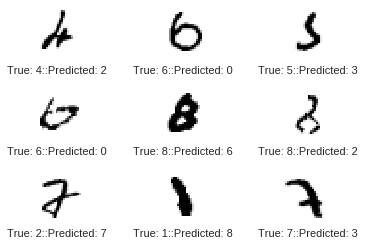

In [96]:
print_test_accuracy(show_example_errors=True)

**Performance after 10000 optimization iteration** 

In [97]:
optimize(10000)

Iteration: 0 Training Accuracy: 1.0
Iteration: 100 Training Accuracy: 1.0
Iteration: 200 Training Accuracy: 1.0
Iteration: 300 Training Accuracy: 1.0
Iteration: 400 Training Accuracy: 0.9921875
Iteration: 500 Training Accuracy: 1.0
Iteration: 600 Training Accuracy: 0.99609375
Iteration: 700 Training Accuracy: 1.0
Iteration: 800 Training Accuracy: 0.99609375
Iteration: 900 Training Accuracy: 1.0
Iteration: 1000 Training Accuracy: 0.9921875
Iteration: 1100 Training Accuracy: 1.0
Iteration: 1200 Training Accuracy: 0.99609375
Iteration: 1300 Training Accuracy: 1.0
Iteration: 1400 Training Accuracy: 1.0
Iteration: 1500 Training Accuracy: 1.0
Iteration: 1600 Training Accuracy: 1.0
Iteration: 1700 Training Accuracy: 1.0
Iteration: 1800 Training Accuracy: 1.0
Iteration: 1900 Training Accuracy: 0.99609375
Iteration: 2000 Training Accuracy: 1.0
Iteration: 2100 Training Accuracy: 1.0
Iteration: 2200 Training Accuracy: 0.99609375
Iteration: 2300 Training Accuracy: 1.0
Iteration: 2400 Training Accu

Accuracy: 0.9925
Example errors: 


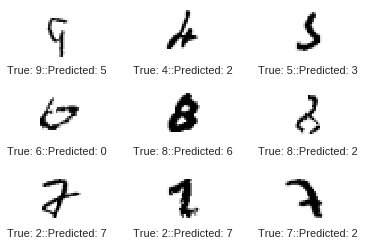

Confusion Matrix: 
[[ 979    0    0    0    0    0    0    0    1    0]
 [   0 1132    1    0    0    0    0    0    2    0]
 [   0    0 1024    1    1    0    0    4    2    0]
 [   0    0    0 1007    0    2    0    1    0    0]
 [   0    0    1    0  976    0    0    0    0    5]
 [   2    0    0    6    0  883    1    0    0    0]
 [   3    2    0    0    1    2  950    0    0    0]
 [   0    3    4    0    0    0    0 1017    1    3]
 [   2    0    1    3    0    1    2    1  963    1]
 [   0    0    0    2    6    2    0    3    2  994]]


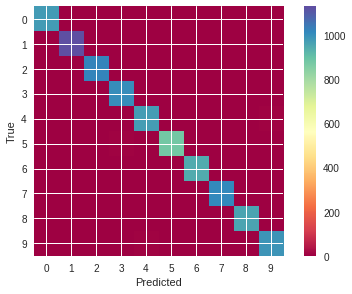

In [100]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

**Performance after 20000 optimization iteration** 

In [102]:
optimize(20000)

Iteration: 0 Training Accuracy: 1.0
Iteration: 1000 Training Accuracy: 1.0
Iteration: 2000 Training Accuracy: 1.0
Iteration: 3000 Training Accuracy: 1.0
Iteration: 4000 Training Accuracy: 1.0
Iteration: 5000 Training Accuracy: 1.0
Iteration: 6000 Training Accuracy: 1.0
Iteration: 7000 Training Accuracy: 0.99609375
Iteration: 8000 Training Accuracy: 1.0
Iteration: 9000 Training Accuracy: 1.0
Iteration: 10000 Training Accuracy: 1.0
Iteration: 11000 Training Accuracy: 1.0
Iteration: 12000 Training Accuracy: 1.0
Iteration: 13000 Training Accuracy: 1.0
Iteration: 14000 Training Accuracy: 1.0
Iteration: 15000 Training Accuracy: 1.0
Iteration: 16000 Training Accuracy: 1.0
Iteration: 17000 Training Accuracy: 1.0
Iteration: 18000 Training Accuracy: 1.0
Iteration: 19000 Training Accuracy: 1.0
Time Usage: 233.2251148223877


Accuracy: 0.9926
Example errors: 


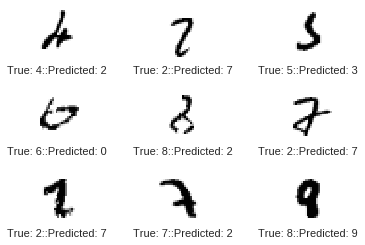

Confusion Matrix: 
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1132    1    0    0    0    0    0    2    0]
 [   0    0 1026    0    1    0    0    5    0    0]
 [   0    0    0 1009    0    1    0    0    0    0]
 [   0    0    1    0  975    0    0    0    1    5]
 [   1    0    0    5    0  885    1    0    0    0]
 [   3    2    1    0    1    2  949    0    0    0]
 [   0    2    5    0    0    0    0 1016    1    4]
 [   1    0    2    3    0    2    0    0  963    3]
 [   0    0    0    1    7    4    0    5    1  991]]


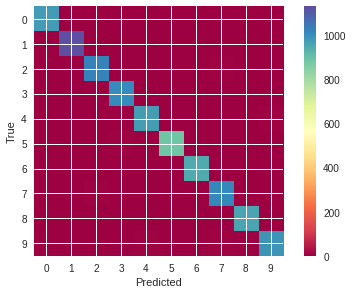

In [103]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

**Visualisation of weights and layers**

*Helper function for plotting convolutional weights*

In [0]:
def plot_conv_weights(weights,input_channel=0):
  w = sess.run(weights)
  
  w_min = np.min(w)
  w_max = np.max(w)
  
  n_filters = w.shape[-1]
  num_grids = math.ceil(math.sqrt(n_filters))
  
  fig,axes = plt.subplots(num_grids,num_grids)
  
  i=0
  for indx, ax in enumerate(axes.flat):
    if i < n_filters:
      img = w[:,:,input_channel,i]
      
      ax.imshow(img,cmap='seismic',vmin=w_min,vmax=w_max,interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    
  plt.show()

**Helper Function for plotting the output of the convolutional layer**

In [0]:
def plot_conv_layer(layer,image):
  feed_dict = {X:[image]}
  
  values = sess.run(layer,feed_dict=feed_dict)
  print(values.shape)
  n_filters = values.shape[-1]
  num_grids = math.ceil(math.sqrt(n_filters))
  
  fig,axes = plt.subplots(num_grids,num_grids)
  i=0
  for indx, ax in enumerate(axes.flat):
    if i < n_filters:
      img = values[0,:,:,i]
      
      ax.imshow(img,cmap='binary',interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    
  plt.show()

**Input Images**

In [0]:
def plot_image(image):
  plt.imshow(image.reshape(img_shape),interpolation='nearest',cmap='binary')
  
  plt.show()

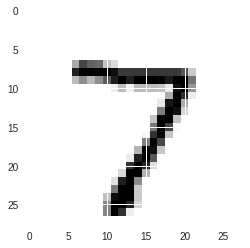

In [107]:
img1 = data.test.images[0]
plot_image(img1)

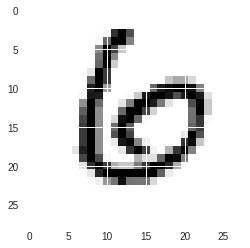

In [110]:
img2 = data.test.images[11]
plot_image(img2)

In [0]:
sess.close()